# Object Detection

This notebook shows how to introduce an object detector from tensorflow_hub and how to detect images in base64 data type for further application.

Codes in this notebook is inspired by <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/object_detection"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" style="height: 25px; width: 25px" />Object Detection Iin TensorFlow</a>

## Setup


In [1]:
import random
from pathlib import Path

# For running inference on the TF-Hub module.
import tensorflow as tf
import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.5.0
The following GPU devices are available: /device:GPU:0


## Apply Object detector Algorithm

Pick an object detection module and apply on my own image. Modules:
* **FasterRCNN+InceptionResNet V2**: high accuracy, [link](https://www.kaggle.com/models/google/faster-rcnn-inception-resnet-v2/tensorFlow1/faster-rcnn-openimages-v4-inception-resnet-v2/1?tfhub-redirect=true)
* **ssd+mobilenet V2**: small and fast. [link](https://www.kaggle.com/models/tensorflow/ssd-mobilenet-v2/code)

In [2]:
# MobileNetV2: "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
# Inception_ResNetV2: "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" 
detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [3]:
test_imgs_path = 'test_images'
cat_imgs = [ cat_img for cat_breed_dir in Path(test_imgs_path).joinpath('cats').iterdir() \
                     for cat_img in cat_breed_dir.iterdir() ]
dog_imgs = [ dog_img for dog_breed_dir in Path(test_imgs_path).joinpath('dogs').iterdir() \
                     for dog_img in dog_breed_dir.iterdir() ]

In [4]:
def load_img(path):
    """Load image via tensorflow io API"""
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

def display_image(image):
    """Display image with no grid and axis"""
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(image)

def draw_bounding_box_on_image(image,
                               ymin, xmin, ymax, xmax,
                               color, font,
                               thickness=1,
                               display_str_list=()):
    """
    Adds a bounding box to an image.

    Parameters:
        image: The image on which the bounding box will be drawn, typically a PIL image object.
        ymin, xmin, ymax, xmax: Coordinates that define the bounding box in relative terms (values between 0 and 1), 
                                where ymin is the top edge, ymax is the bottom edge, 
                                xmin is the left edge, and xmax is the right edge.
        color: The color of the bounding box, specified as an RGB tuple.
        font: A PIL font object used for rendering text labels.
        thickness: The thickness of the bounding box's lines (default is 1).
        display_str_list: A tuple of strings that will be displayed near the bounding box.
    
    This function calculates absolute coordinates from relative values,
    draws a bounding box, and overlays text labels either above or below
    the box based on available space, ensuring clear visibility.
    """
    # --------------------------------------------------------------------------------
    # 1. Creates a drawing context on the provided image.
    # 2. Calculate Absolute Coordinates:
    # The relative coordinates (ymin, xmin, ymax, xmax) are multiplied by 
    # the image width and height to convert them into pixel values:
    # --> left, right: The left and right edges of the bounding box.
    # --> top, bottom: The top and bottom edges of the bounding box.
    # 3. Draw the Bounding Box:
    # Draws a line around the bounding box using the calculated coordinates, specified color, and thickness.
    # --------------------------------------------------------------------------------
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
              width=thickness,
              fill=color)

    # --------------------------------------------------------------------------------
    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    # getbbox -> return (xmin, ymin, xmax, ymax)
    # --------------------------------------------------------------------------------
    display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]

    # --------------------------------------------------------------------------------
    # The total height needed for the display strings, including some margin
    # Each display_str has a top and bottom margin of 0.05x.
    # --------------------------------------------------------------------------------
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    # Determine position for text based on bounding box location
    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height

    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        bbox = font.getbbox(display_str)
        text_width, text_height = bbox[2], bbox[3]
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin

def draw_one_boxes(image, boxes, class_names, scores):
    """Overlay labeled boxes on an image with formatted scores and label names.
    
    Parameters:
        image: Input image as a NumPy array.
        boxes: Tuple of bounding box coordinates (ymin, xmin, ymax, xmax) in relative format.
        class_names: Class name of the detected object as a byte string.
        scores: Confidence score of the detection (0 to 1).

    This function converts the input image to PIL format, draws a bounding box
    with a specified color, and overlays formatted class names and scores. 
    It ensures different colors for different classes by hashing the class names.
    """
    
    colors = list(ImageColor.colormap.values())  # Get a list of colors for bounding boxes.

    font = ImageFont.load_default()  # Load default font for text labels.
    
    ymin, xmin, ymax, xmax = tuple(boxes)  # Unpack bounding box coordinates.
    display_str = "{}: {}%".format(class_names.decode("ascii"), int(100 * scores))  # Format display string.
    color = colors[hash(class_names) % len(colors)]  # Choose color based on class name hash.
    
    image_pil = Image.fromarray(np.uint8(image)).convert("RGB")  # Convert NumPy image to PIL format.
    
    # Draw the bounding box on the PIL image.
    draw_bounding_box_on_image(image_pil, 
                               ymin, xmin, ymax, xmax,
                               color, font,
                               display_str_list=[display_str])
    
    np.copyto(image, np.array(image_pil))  # Copy modified image back to NumPy array.
    return image  # Return the updated image with bounding box and labels.

def run_detector_one_img(detector, path):
    img = load_img(path)

    # detector inference
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    result = detector(converted_img)
    result = {key:value.numpy() for key,value in result.items()}

    # draw result
    image_with_boxes = draw_one_boxes(img.numpy(), result["detection_boxes"][0],
                                      result["detection_class_entities"][0], result["detection_scores"][0])
    
    display_image(image_with_boxes)
    object_class = result["detection_class_entities"][0].decode('utf-8')
    
    return (object_class, image_with_boxes)

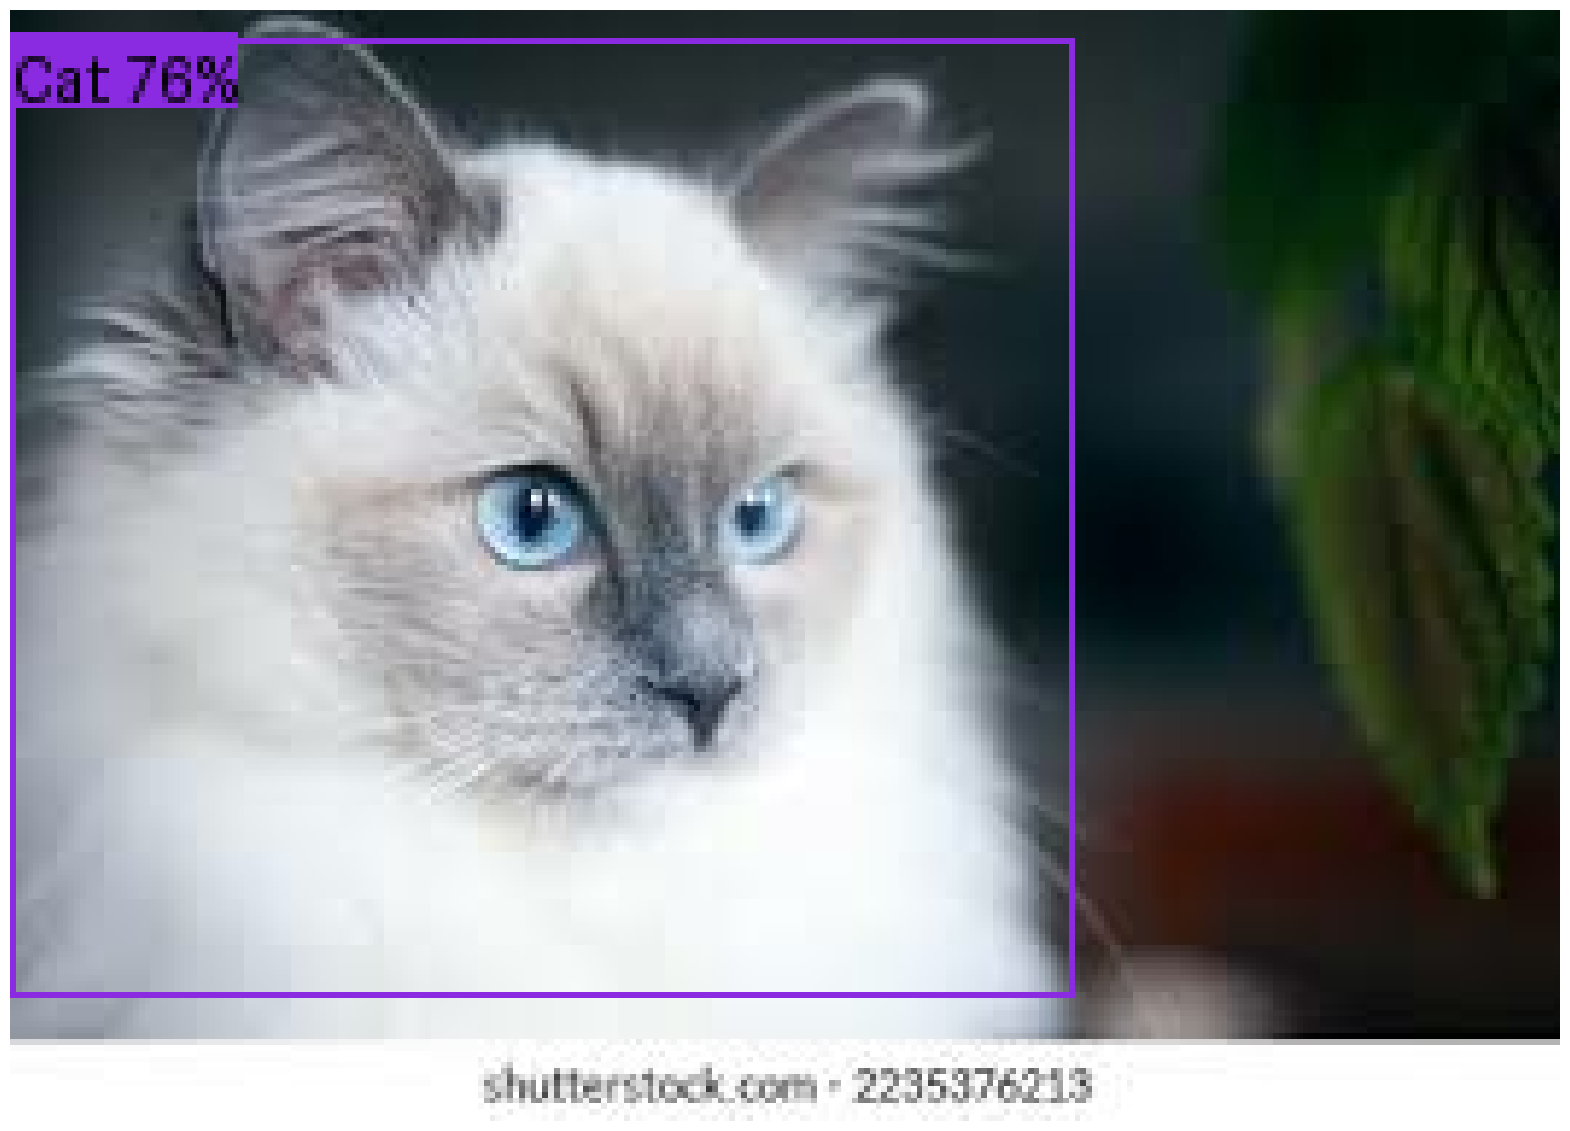

In [5]:
my_img_path = str(random.choice(cat_imgs))
object_class, image_with_boxes = run_detector_one_img(detector, my_img_path)

(str, 'Cat')

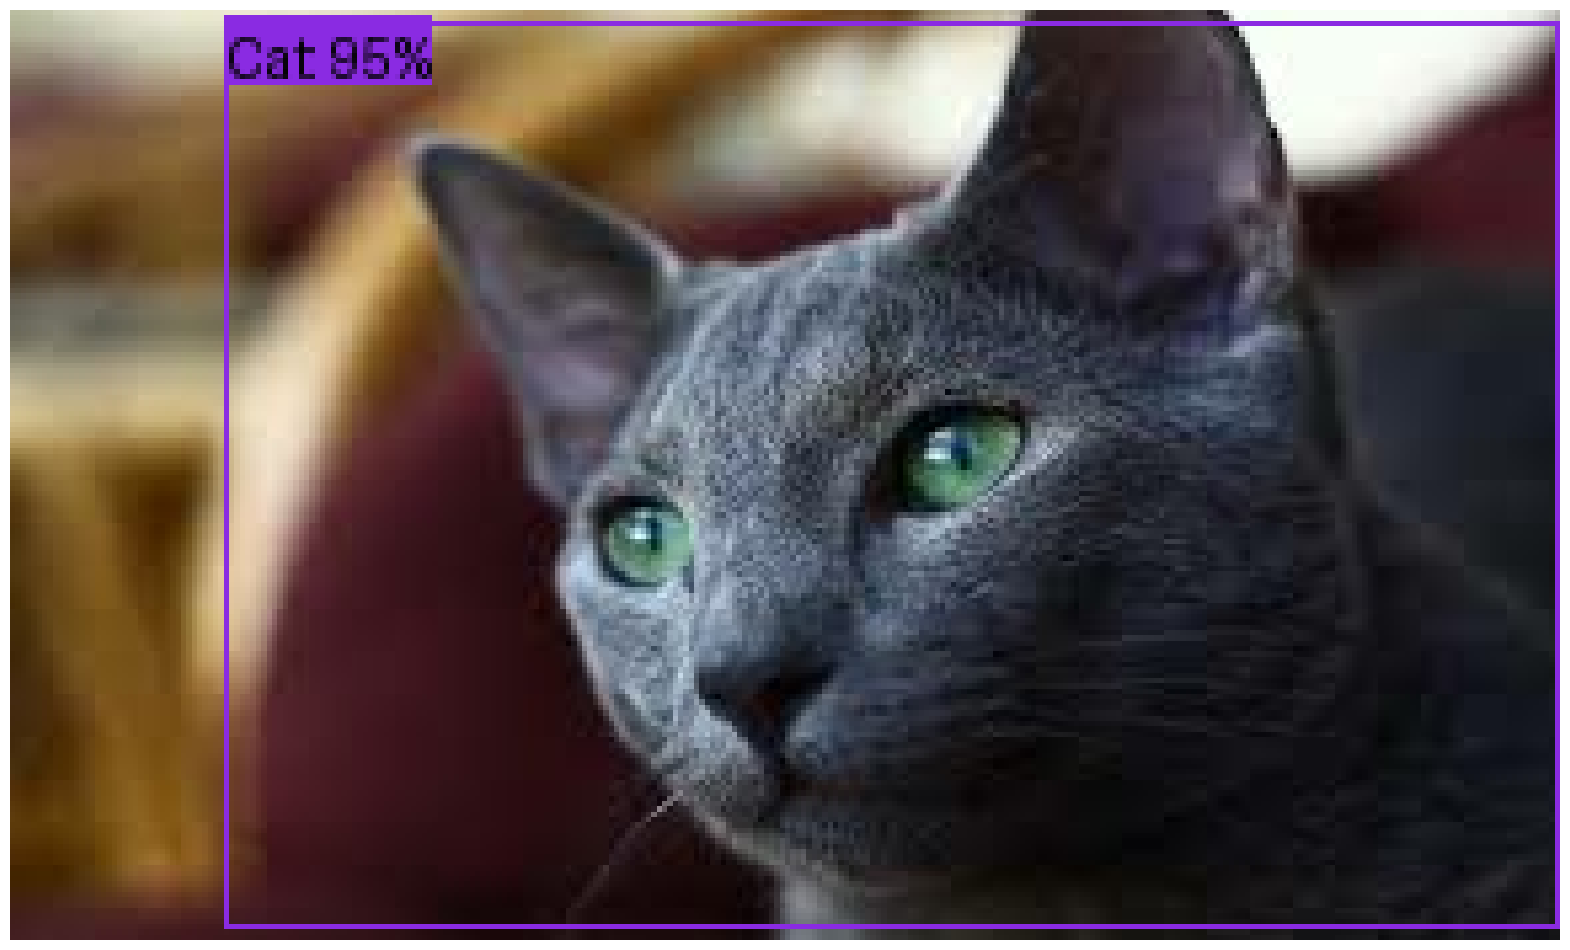

In [6]:
my_img_path = str(random.choice(cat_imgs))
object_class, image_with_boxes = run_detector_one_img(detector, my_img_path)
type(object_class), object_class

## Load image in base64 data type

In [7]:
import base64 # ok
import numpy as np # ok
import tensorflow as tf 
from PIL import Image, ImageDraw, ImageFont, ImageColor
import matplotlib.pyplot as plt

def load_img_from_base64(base64_str):
    """Load image from a Base64 string."""
    # Decode the Base64 string
    img_data = base64.b64decode(base64_str)
    # Convert to a NumPy array
    img = tf.image.decode_jpeg(img_data, channels=3)
    return img

def display_image(image):
    """Display image with no grid and axis"""
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(image)

def draw_bounding_box_on_image(image,
                               ymin, xmin, ymax, xmax,
                               color, font,
                               thickness=1,
                               display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
              width=thickness,
              fill=color)

    display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height

    for display_str in display_str_list[::-1]:
        bbox = font.getbbox(display_str)
        text_width, text_height = bbox[2], bbox[3]
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin

def draw_one_boxes(image, boxes, class_names, scores):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())
    font = ImageFont.load_default()
    
    ymin, xmin, ymax, xmax = tuple(boxes)
    display_str = "{}: {}%".format(class_names.decode("ascii"), int(100 * scores))
    color = colors[hash(class_names) % len(colors)]
    
    image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
    
    draw_bounding_box_on_image(image_pil, 
                               ymin, xmin, ymax, xmax,
                               color, font,
                               display_str_list=[display_str])
    
    np.copyto(image, np.array(image_pil))
    return image

def run_detector_one_img(detector, base64_str):
    img = load_img_from_base64(base64_str)

    # Detector inference
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    result = detector(converted_img)
    result = {key: value.numpy() for key, value in result.items()}

    # Draw result
    image_with_boxes = draw_one_boxes(img.numpy(), result["detection_boxes"][0],
                                      result["detection_class_entities"][0], result["detection_scores"][0])
    
    display_image(image_with_boxes)
    object_class = result["detection_class_entities"][0].decode('utf-8')
    
    return (object_class, image_with_boxes)

In [8]:
def read_base64_from_file(fpath):
    """Read Base64 string from txt file"""
    with open(fpath, 'r') as file:
        return file.read()

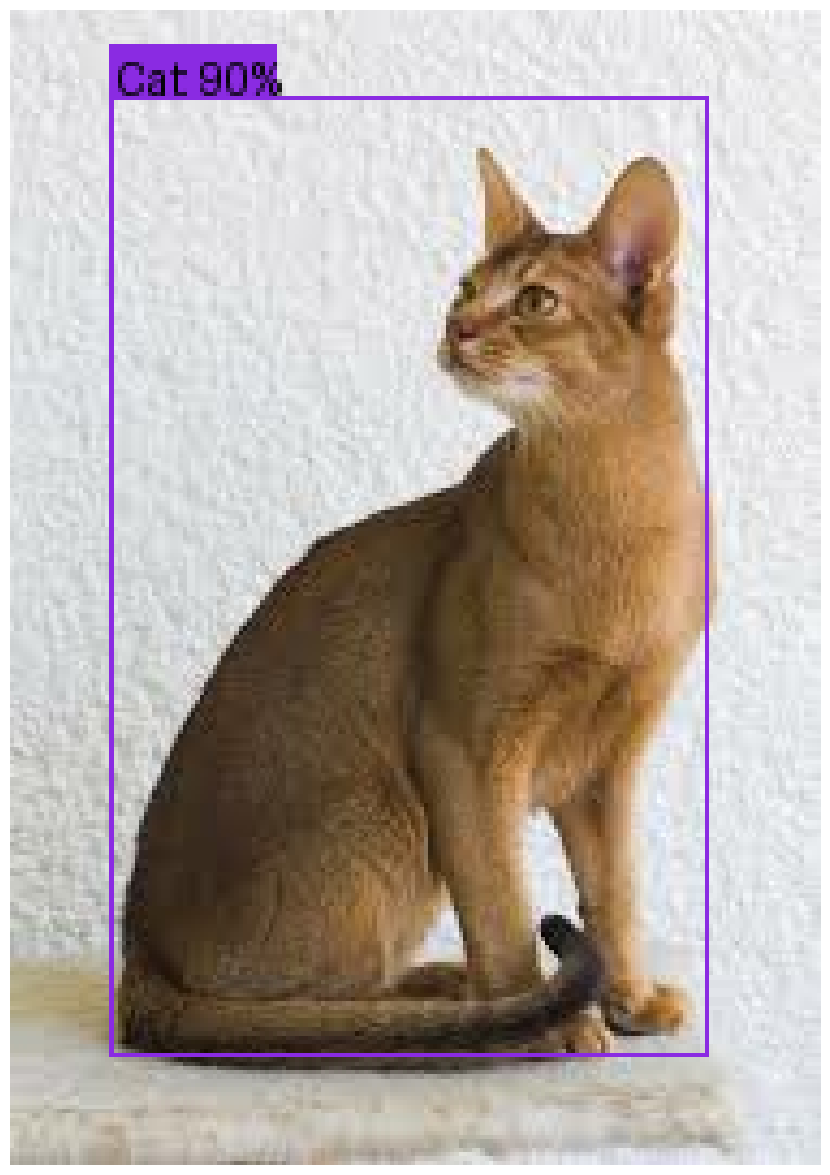

In [10]:
cat_bytes = read_base64_from_file("user_img.txt")
object_class, image_with_boxes = run_detector_one_img(detector, cat_bytes)